# Forced frequency resolution with PCA
Over-binning can be spotted with PCA. Loop-like patters will appear 

In [15]:
import os, sys
sys.path.insert(1, os.getcwd()+'/..')
if (os.getcwd()[-7:] == 'reports'):
    os.chdir('..')
from internal import *

### Create sinthetic signals
We create seleral sinthetic signals for testing.

We simulate having 5 sensor measuring for 30 seconds.
We generate several frequencies that are detected with different amplitudes in each fo the sensors (each sensor is more sensible than the last).


In [16]:
# Fix the random seed for consistency between simulations
np.random.seed(123)

Forced FFT resolution: 0.02Hz
True FFT resolution: 0.2Hz
Warning!
  The number of FFT bins (5000) is greater than the number of time samples (500). The resulting frequency resolution will not be accurate
Sensor 1 data saved at ./data/simulation_data/empirical_data/sensor_1.mat
Sensor 1 true data saved at ./data/simulation_data/theoretical_data/sensor_1.mat
Sensor 2 data saved at ./data/simulation_data/empirical_data/sensor_2.mat
Sensor 2 true data saved at ./data/simulation_data/theoretical_data/sensor_2.mat
Sensor 3 data saved at ./data/simulation_data/empirical_data/sensor_3.mat
Sensor 3 true data saved at ./data/simulation_data/theoretical_data/sensor_3.mat
Sensor 4 data saved at ./data/simulation_data/empirical_data/sensor_4.mat
Sensor 4 true data saved at ./data/simulation_data/theoretical_data/sensor_4.mat
Sensor 5 data saved at ./data/simulation_data/empirical_data/sensor_5.mat
Sensor 5 true data saved at ./data/simulation_data/theoretical_data/sensor_5.mat


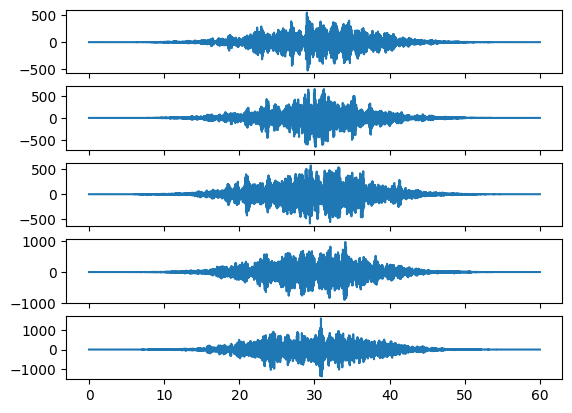

In [17]:

""" Set the parameters """
sr = 100;       # Hz. Sampling rate
t = 60;         # s. Duration of the signal
N = 100;      # Number of different frequencies composing the signal

window = 5.0     # s. Length of the windows in seconds
shift  = window  # s. Length of the window shift in seconds
n_bins = int(window*sr/1);  # Number of bins to use for the DFT calculation
n_bins = n_bins*10


f = [12.0, 13.5, 22.0, 22.15, 32.0, 32.075 ] # Hz. Main frequencies of the simulated signals
sigma_f = 0.5 # standard deviation around the frequencies chosen for the signal generation
sigma_A = 0.5 # standard deviation around the amplitudes chosen for the signal generation

n_sensors = 5; # Number of sensors in the simulation
sensors = []

print(f"Forced FFT resolution: {sr/n_bins}Hz")
print(f"True FFT resolution: {sr/(window*sr)}Hz")
test.bins_check(sr, window, n_bins)

plot = True
if plot: 
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(n_sensors, 1, sharex=True)
    ymax = 0; ymin = 0;

for i in range(n_sensors):

    """ Generate the signal """
    F   = np.zeros(N*len(f))
    A   = np.zeros(N*len(f))
    phi = np.zeros(N*len(f))
    k = -1 
    for f0 in f:
        k += 1
        F[N*k:N*(k+1)] = generate_frequencies(N, sr=sr, f0=f0,sigma=sigma_f);
        center = 10 + i**2 # Cada sensor es más sensible que el anterior
        A[N*k:N*(k+1)] = generate_amplitudes(N, center=center, sigma= sigma_A)
        phi[N*k:N*(k+1)] = generate_phase(N);
    
    sort_ids = F.argsort()
    F   = F[sort_ids]
    A   = A[sort_ids]#*np.tile(np.linspace(0.8,2,N),(1,len(f))); # Skew for different frequencies
    phi = phi[sort_ids]
    x, y = generate_signal(F, A, t=t, sr=sr, phi=phi);
    
    """ Signal convolution """
    x_aux = x - t/2 # Peak on the middle of the signal
    convolution = 1* np.exp(-(x_aux/10)**2)
    y *= convolution
    
    # Plot the signal of each sensor
    if plot:
        ymin = min([ymin, min(y)])
        ymax = max([ymax, max(y)])
        ax[i].plot(x, y)


    """ Create signal object """
    sensors.append(Processor(y, sr))

    """ Apply windowing and calculate FFT """
    sensors[i].set_windows(window, shift);
    sensors[i].fft_bin_window(n_bins)
    # sensors[i].check_fft()

    """ Create data matrix """
    ffts = sensors[i].fft_windows[:, 0:n_bins//2]
    fft_freq = sensors[i].freqs_windows[0:n_bins//2]
    fft_freq_str = [f"{round(freq, 2)} Hz" for freq in fft_freq]

    """ Save the data matrix """
    filepath = f"./data/simulation_data/empirical_data/sensor_{i+1}.mat"
    save(np.abs(ffts), column_names=fft_freq_str, filepath=filepath)
    print(f"Sensor {i+1} data saved at {filepath}")

    """ Create data matrix of the true data"""
    wave = np.sin(np.outer(x, np.pi*2*F)+phi)
    data = np.abs(wave * convolution[:, np.newaxis]) # We take the absolute value of the final signal
    data *= A

    """ Average for the windows """
    data = data.reshape(sensors[i].N_windows, sensors[i].window_samples, N*len(f))
    data = np.mean(data, axis = 1)

    """ Average for the frequency resolution"""
    fft_res = sensors[i].fft_resolution
    n_ffts = sensors[i].n_bins//2
    data_avg = np.zeros((sensors[i].N_windows,n_ffts))
    
    for j in range(n_ffts):
        f_ids = np.where((F>fft_res*j) & (F<=fft_res*(j+1)))[0]
        if f_ids.size > 0:
            aux = data[:, f_ids]
            data_avg[:,j] = aux.mean(axis=1)

    data = np.abs(data_avg)

    """ Save the true data matrix """
    fft_freq += fft_res # Correction for the true data labels
    fft_freq_str = [f"{round(freq, 2)} Hz" for freq in fft_freq]
    filepath = f"./data/simulation_data/theoretical_data/sensor_{i+1}.mat"
    save(data, column_names=fft_freq_str, filepath=filepath)
    print(f"Sensor {i+1} true data saved at {filepath}")


### Apply PCA to the data using the MEDA-Toolbox

In [18]:
# # Template para ejecutar matlab desde aquí
import subprocess

matlab_script = 'main'
subprocess.run(["matlab", "-nodesktop", "-nosplash", "-r", f"cd('MEDA'); {matlab_script};"])

CompletedProcess(args=['matlab', '-nodesktop', '-nosplash', '-r', "cd('MEDA'); main;"], returncode=0)